Saved figure to: D:\DCM_manuscript_figure\Plot_ctbs_final_BST_n1c_segment1T.svg


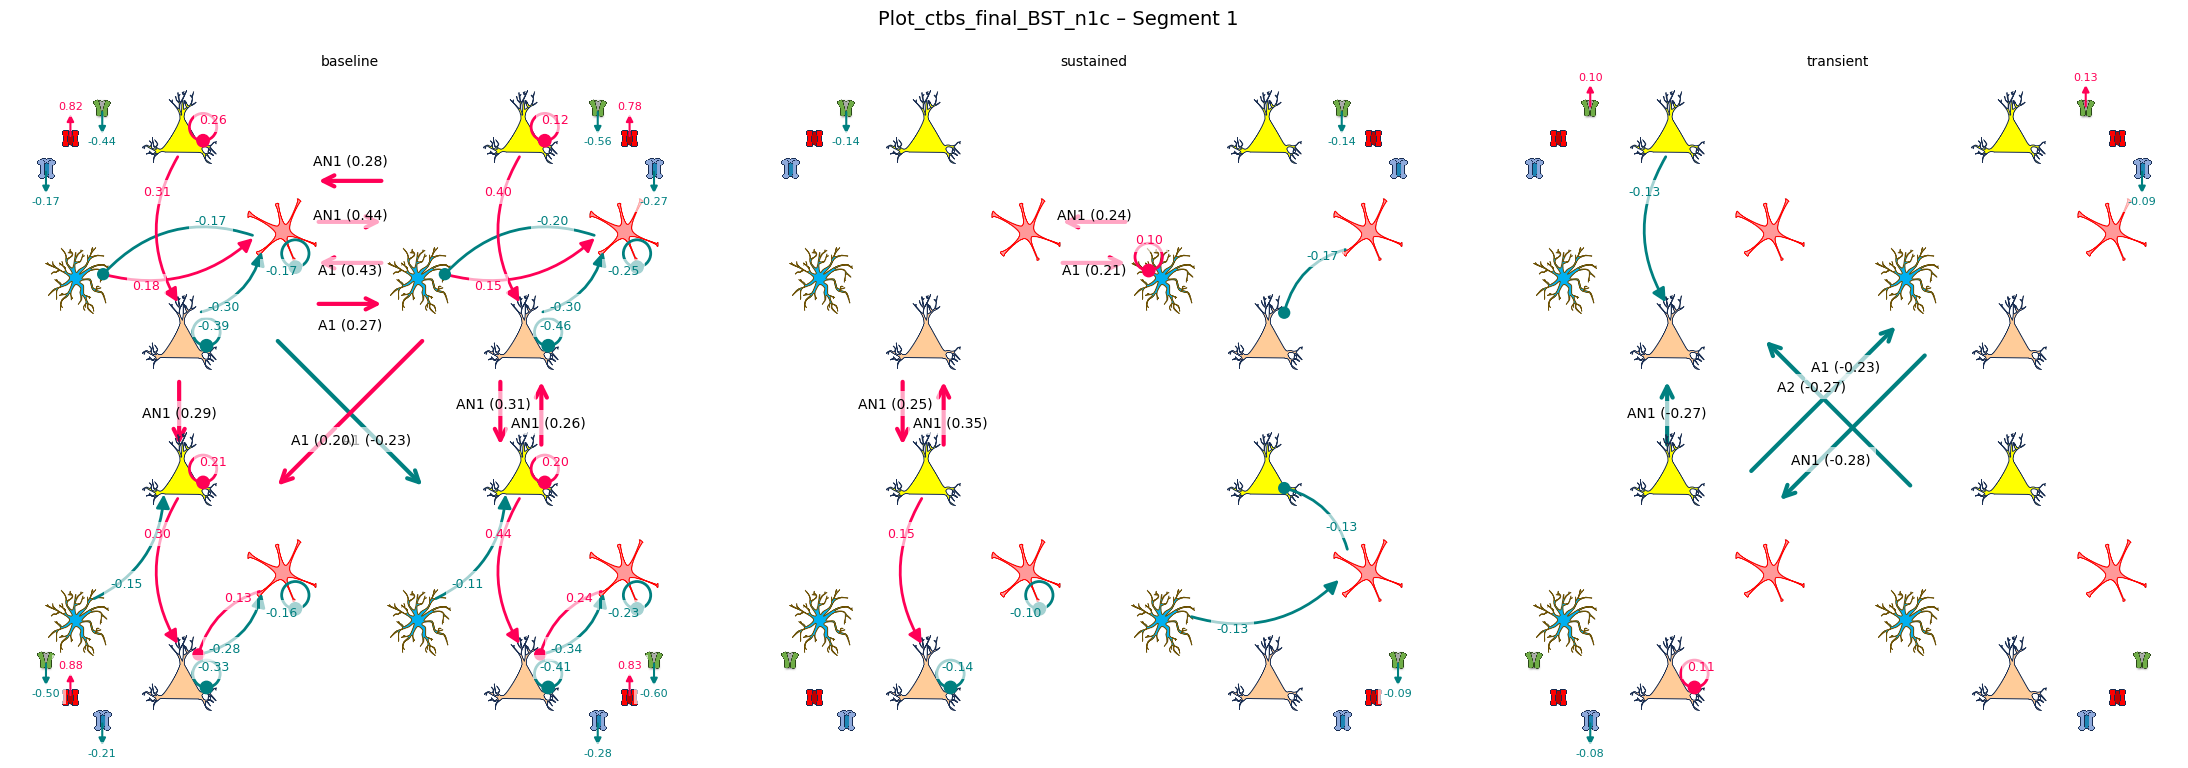

Saved figure to: D:\DCM_manuscript_figure\Plot_itbs_final_BST_n1i_segment1T.svg


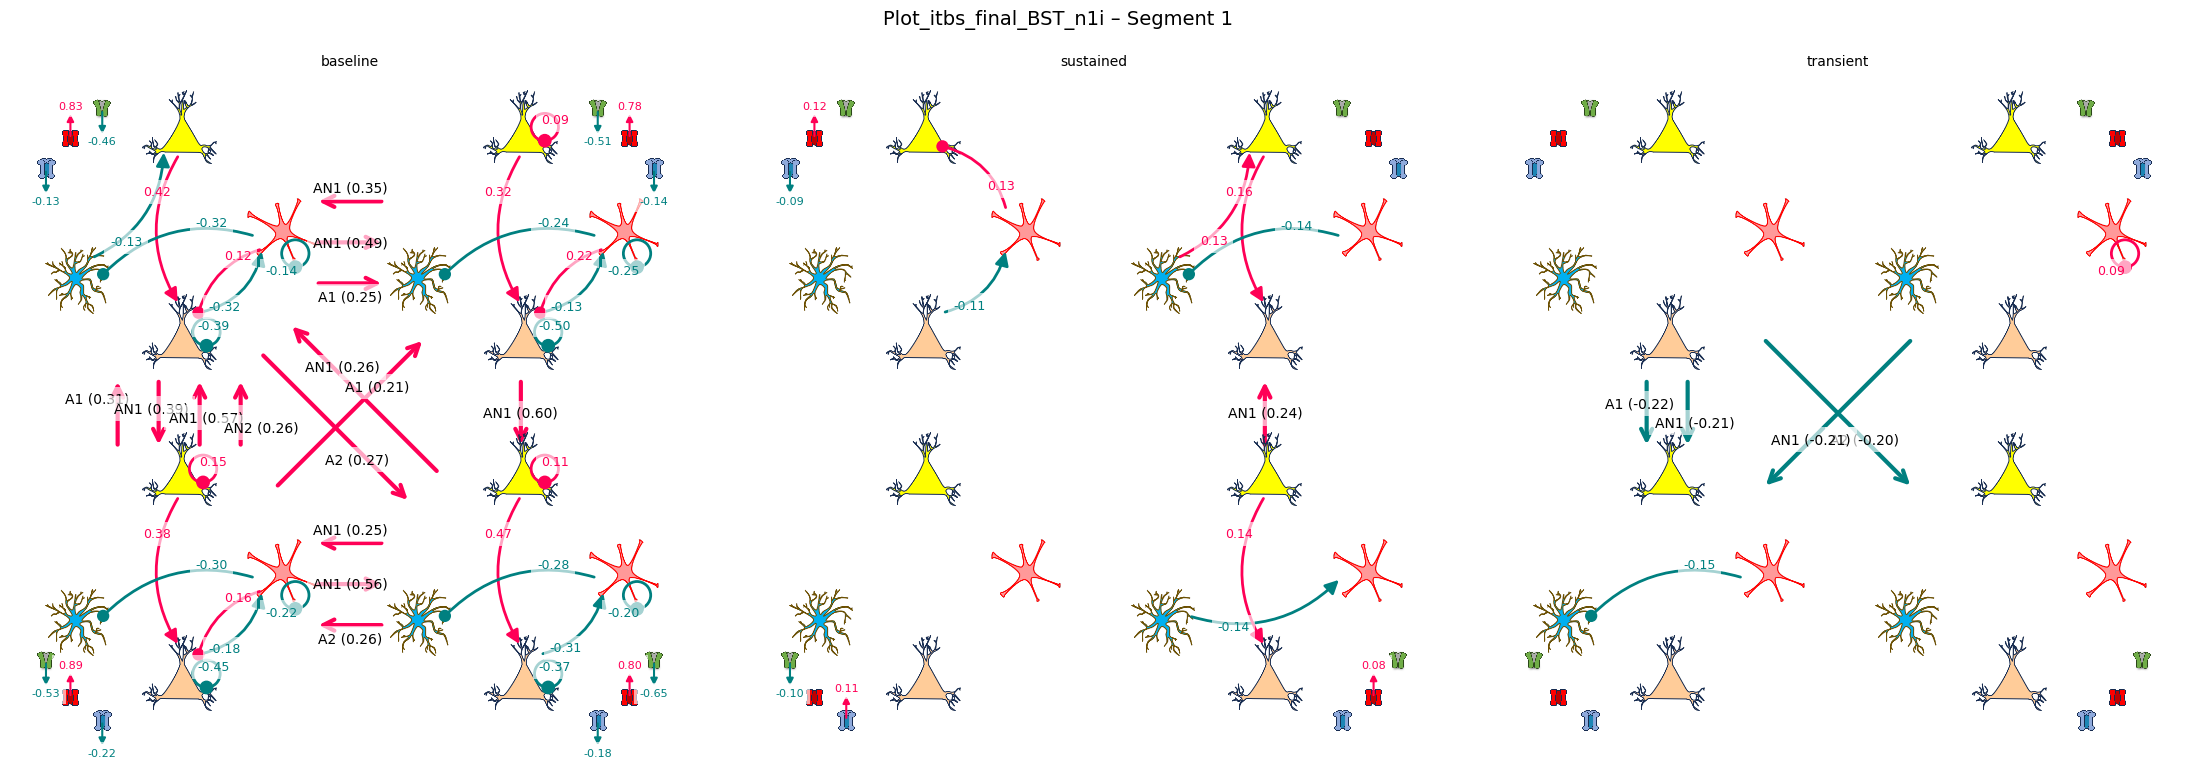

Saved figure to: D:\DCM_manuscript_figure\Plot_sham_final_BST_n1s_segment1T.svg


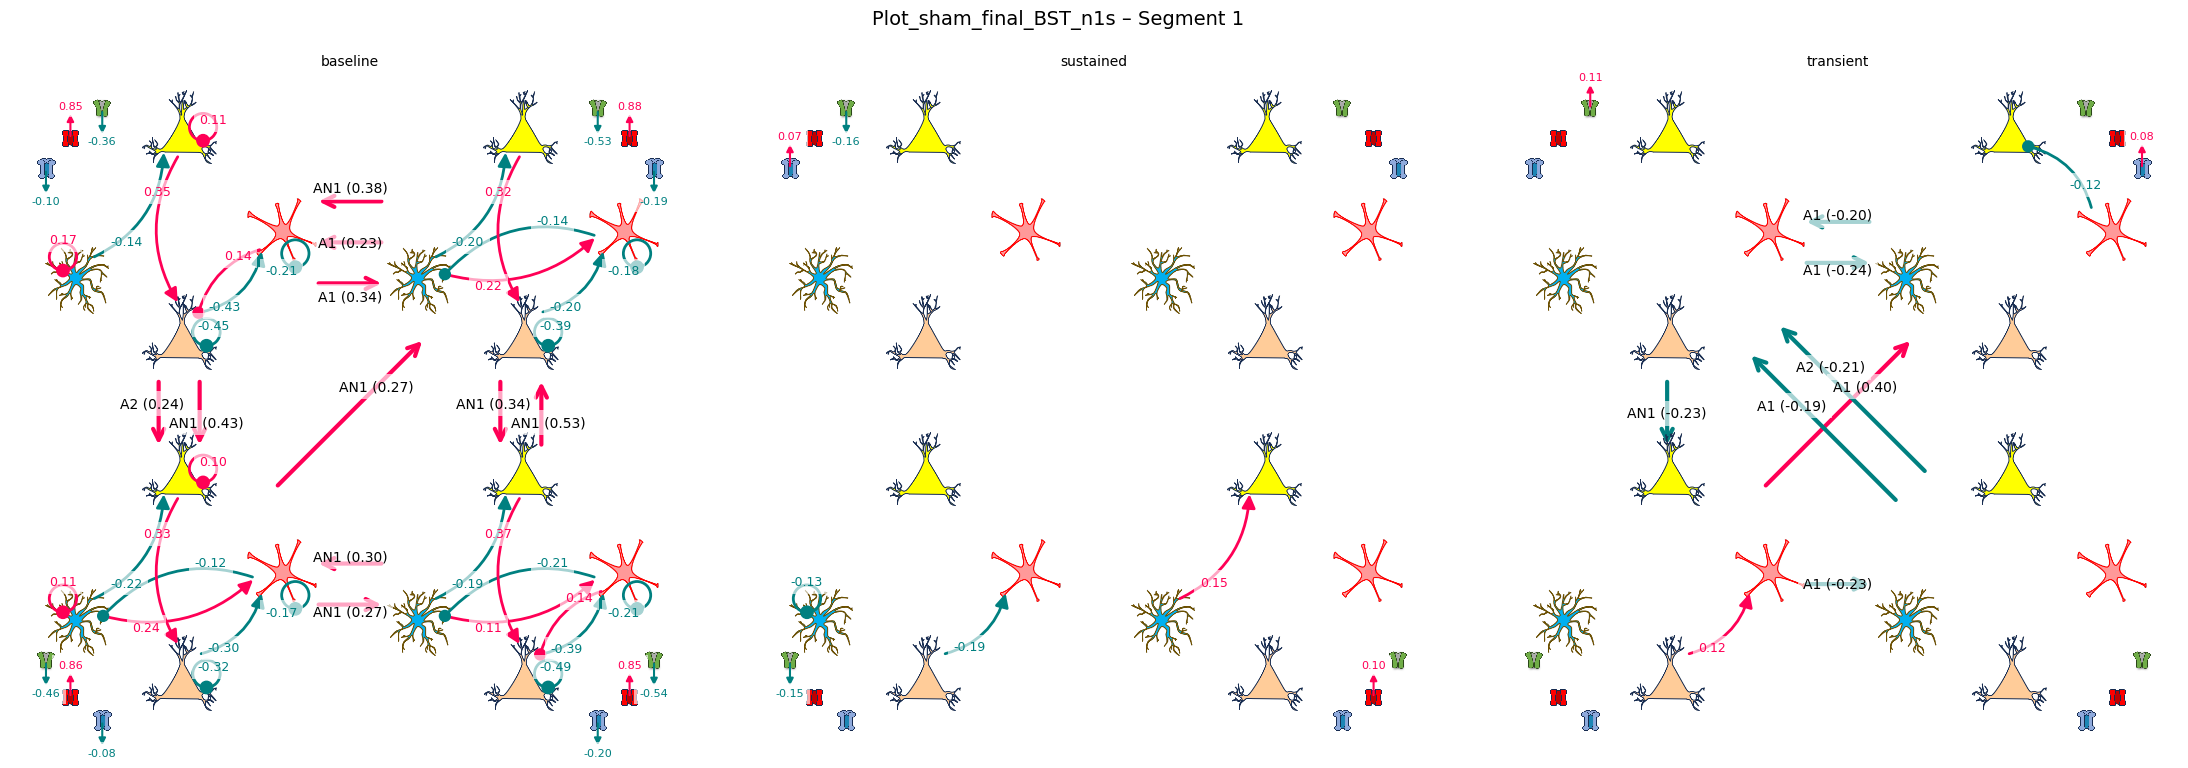

Saved figure to: D:\DCM_manuscript_figure\Plot_ctbs_BST_-1s_1c_segment1T.svg


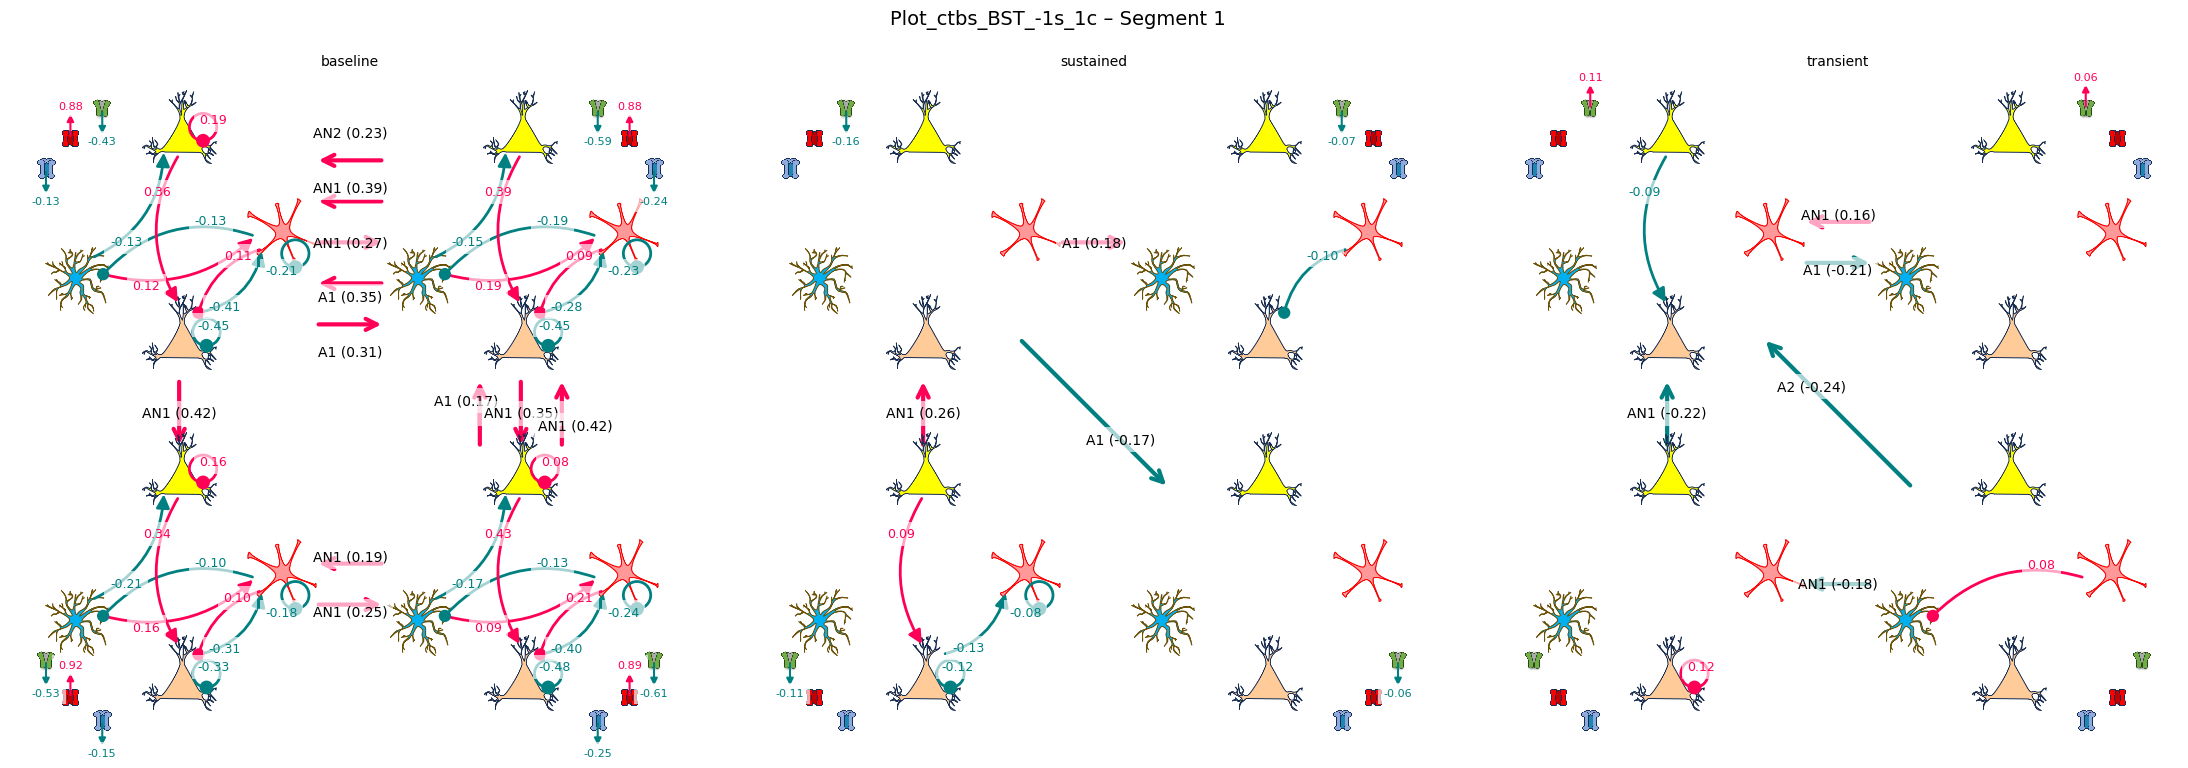

Saved figure to: D:\DCM_manuscript_figure\Plot_ctbs_BST_-1s_1c_segment2T.svg


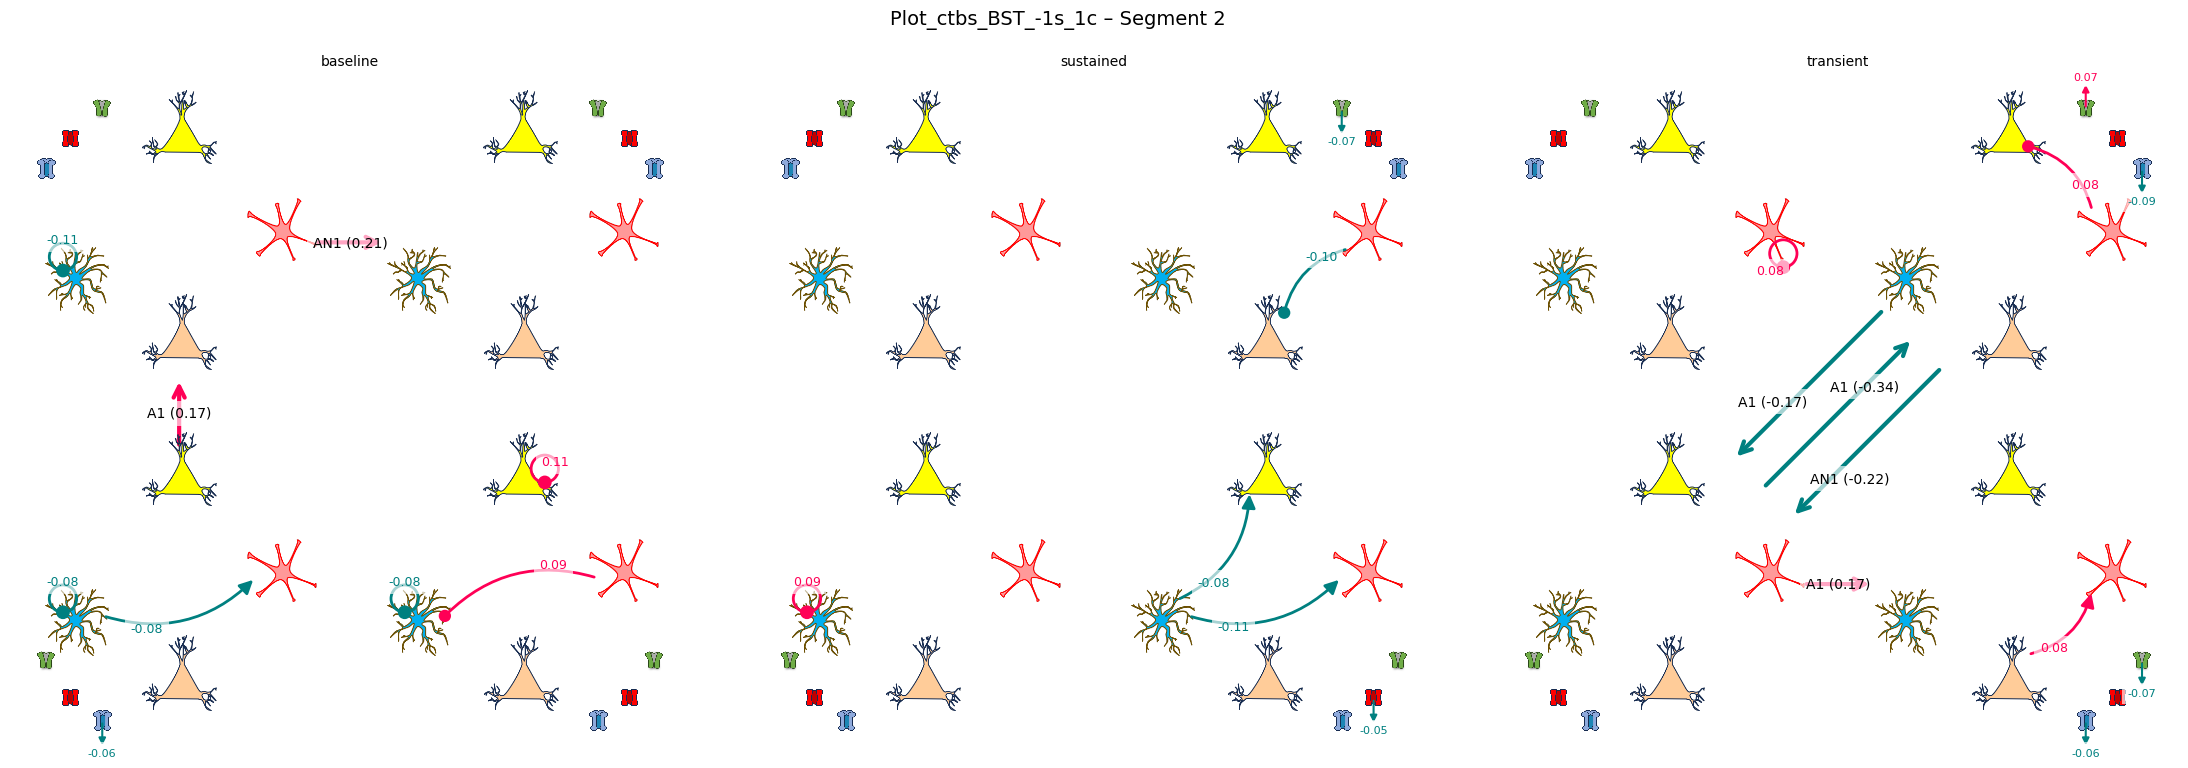

Saved figure to: D:\DCM_manuscript_figure\Plot_itbs_BST_-1s_1i_segment1T.svg


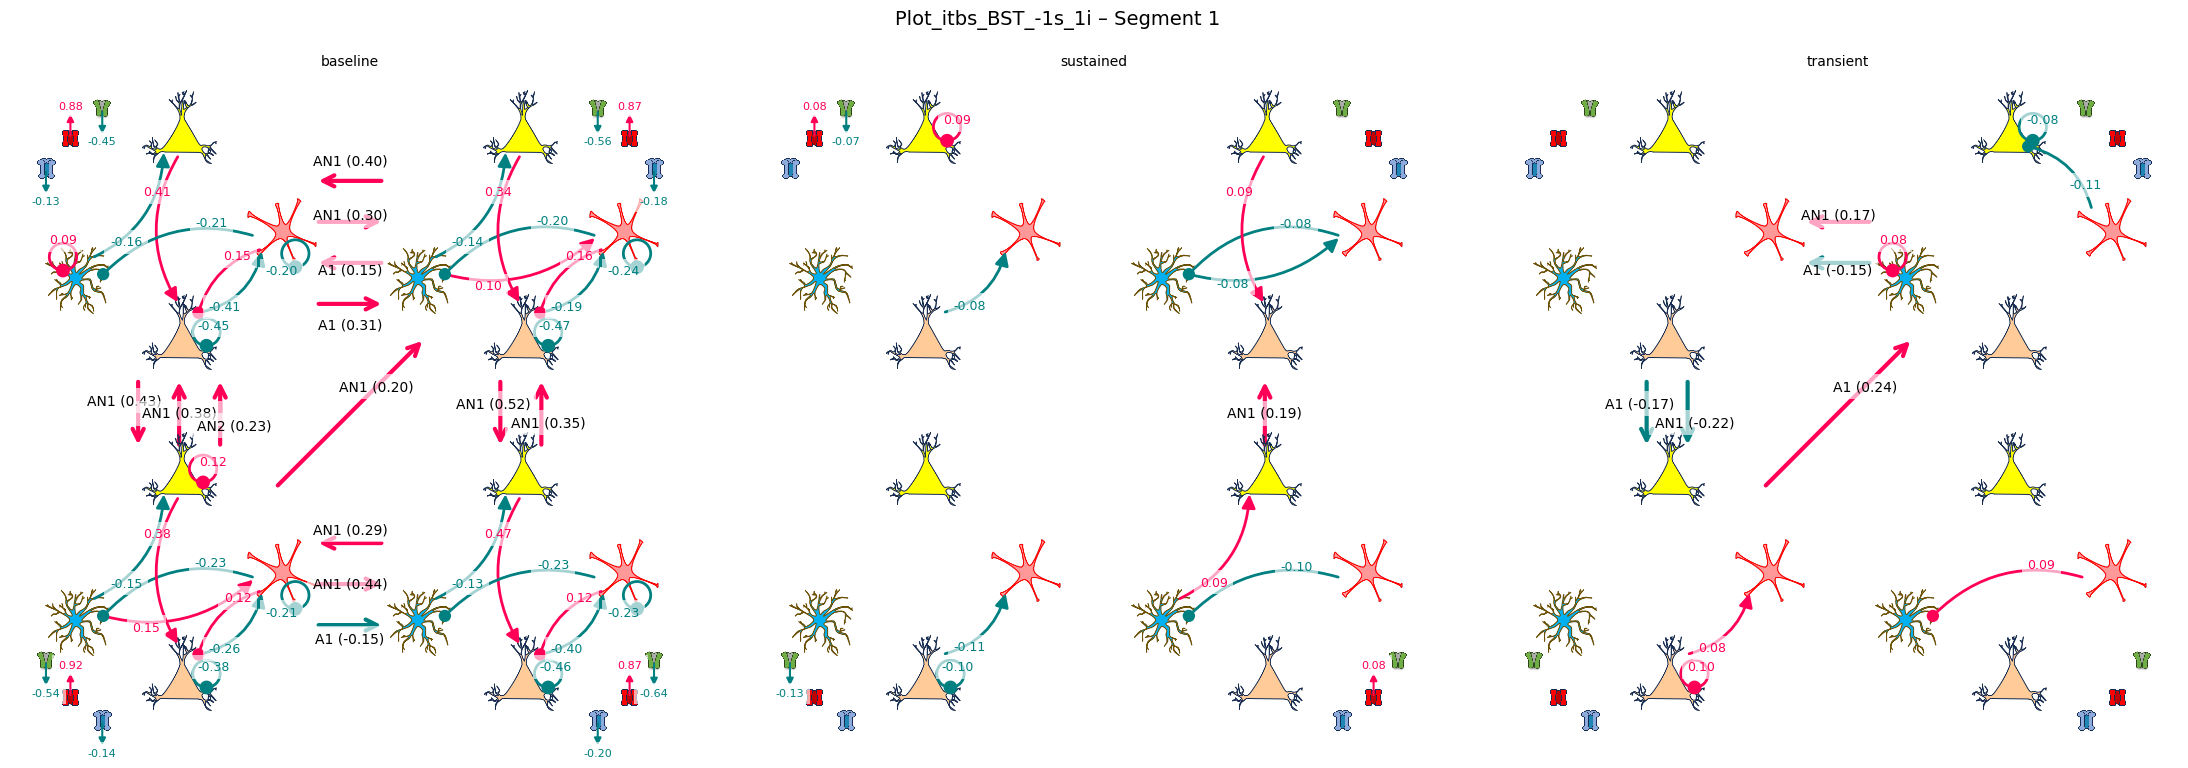

Saved figure to: D:\DCM_manuscript_figure\Plot_itbs_BST_-1s_1i_segment2T.svg


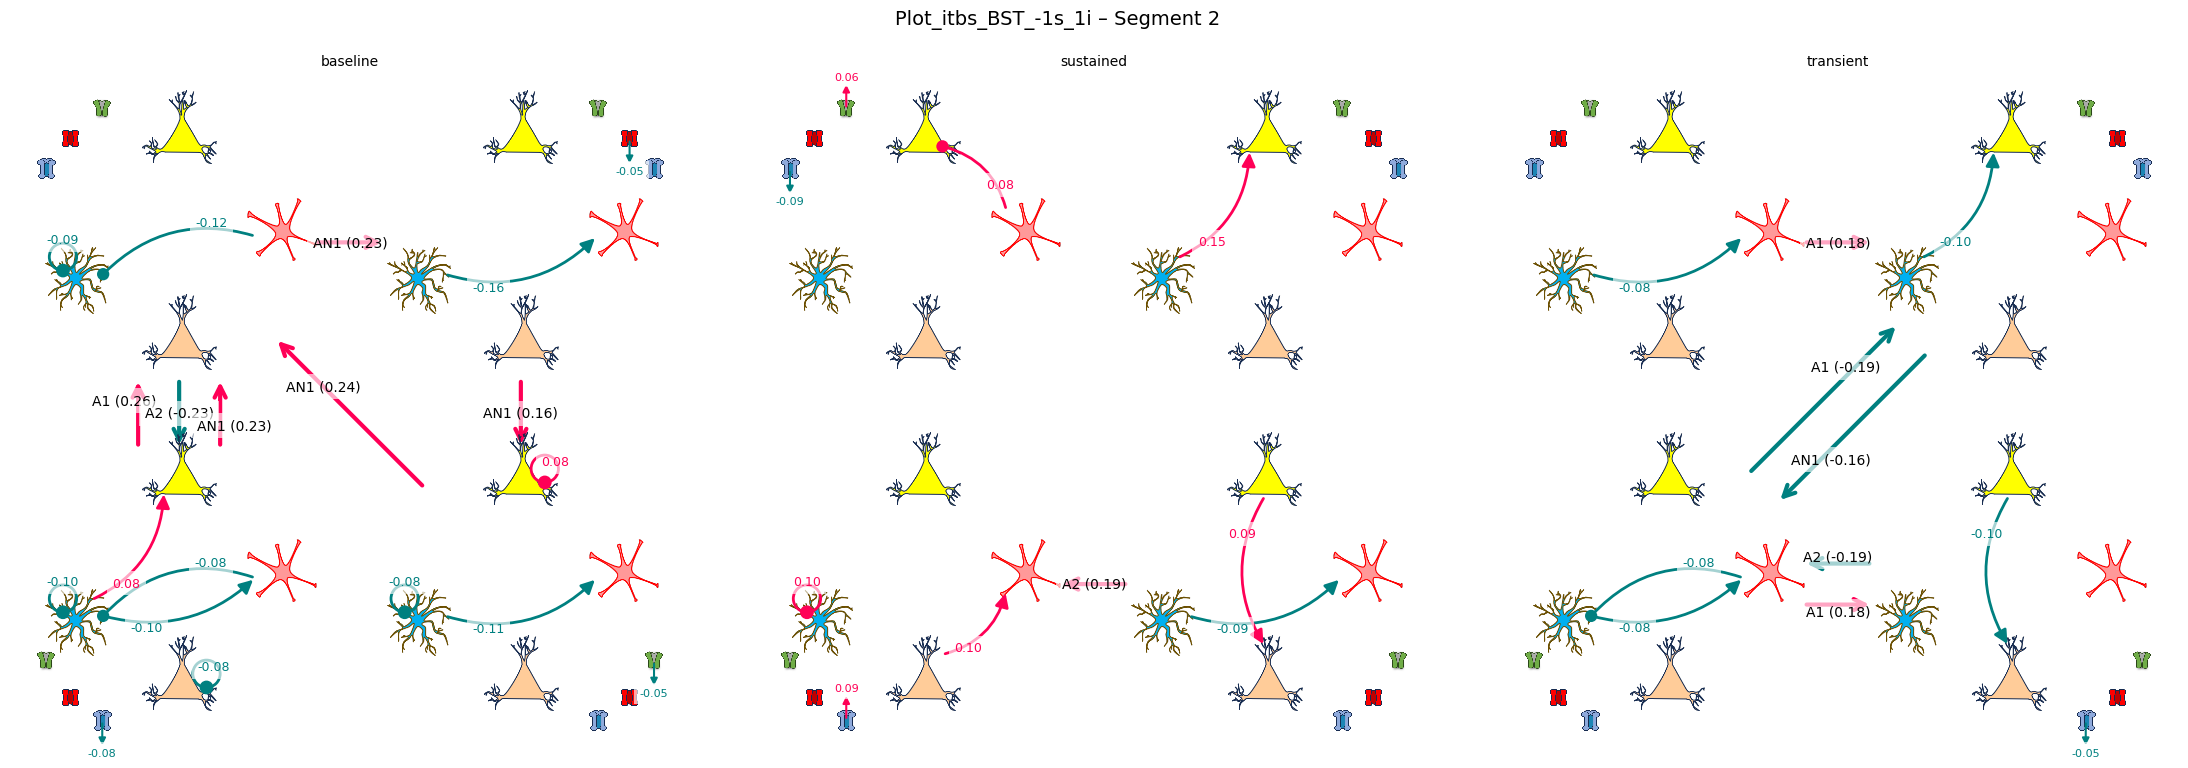

Saved figure to: D:\DCM_manuscript_figure\Plot_cTBSvsiTBS_BST_-1c_1i_segment1T.svg


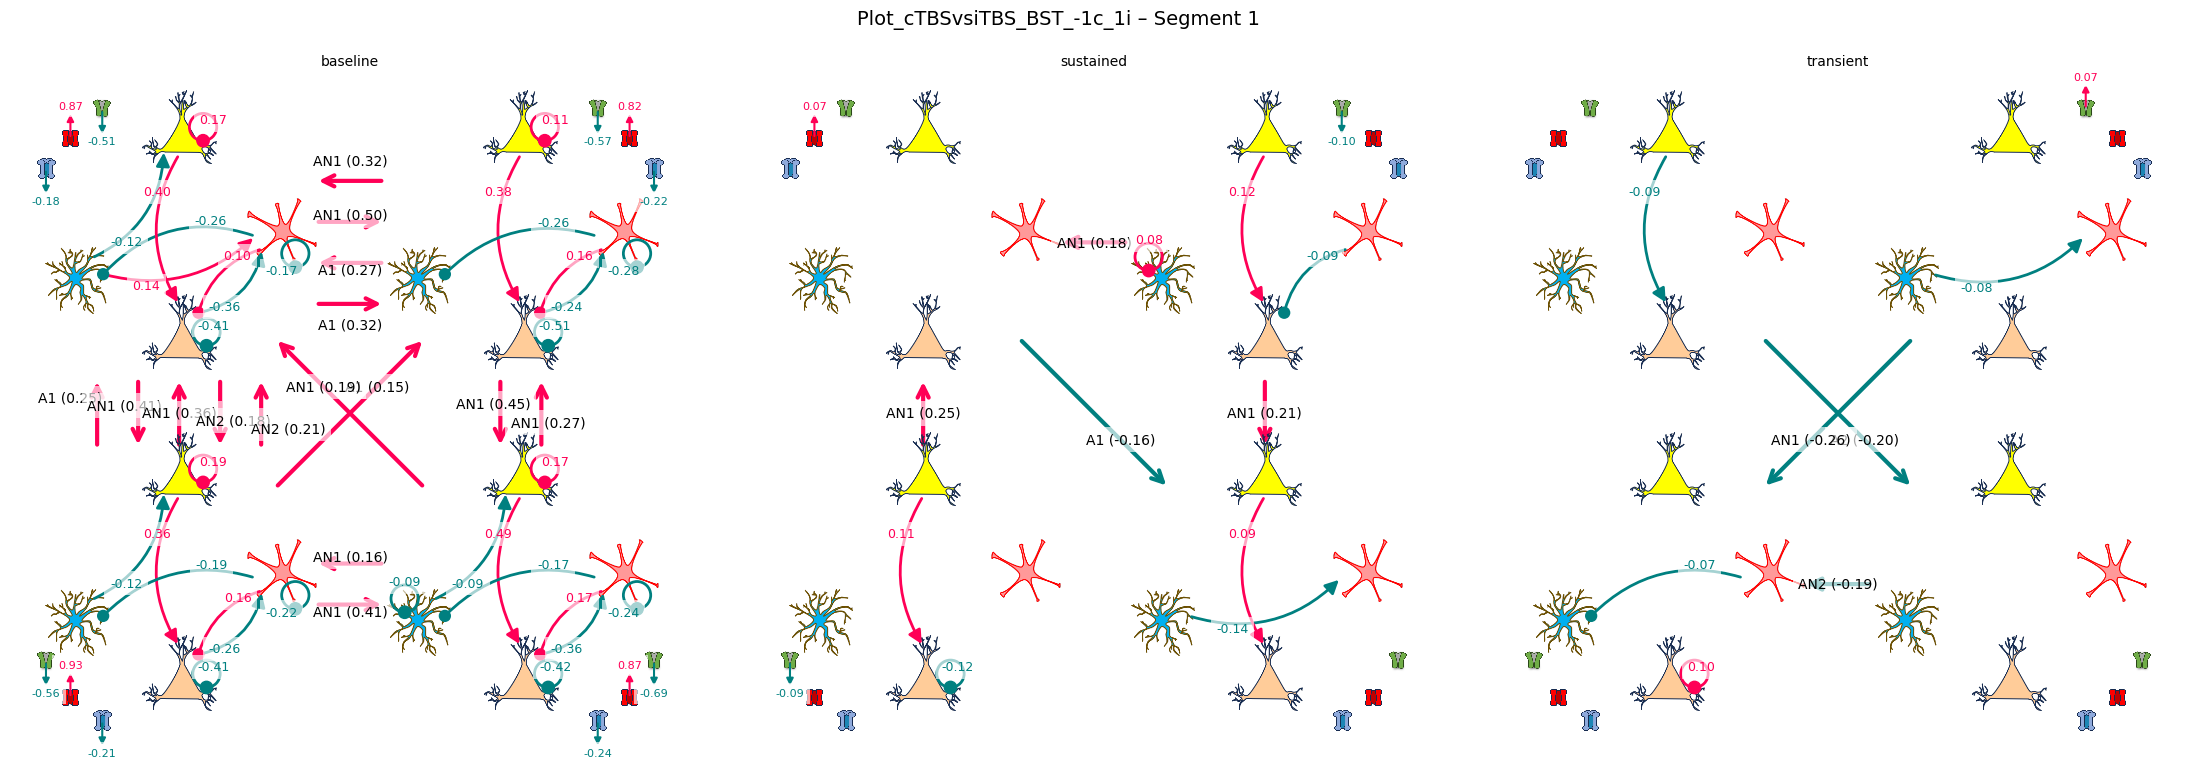

Saved figure to: D:\DCM_manuscript_figure\Plot_cTBSvsiTBS_BST_-1c_1i_segment2T.svg


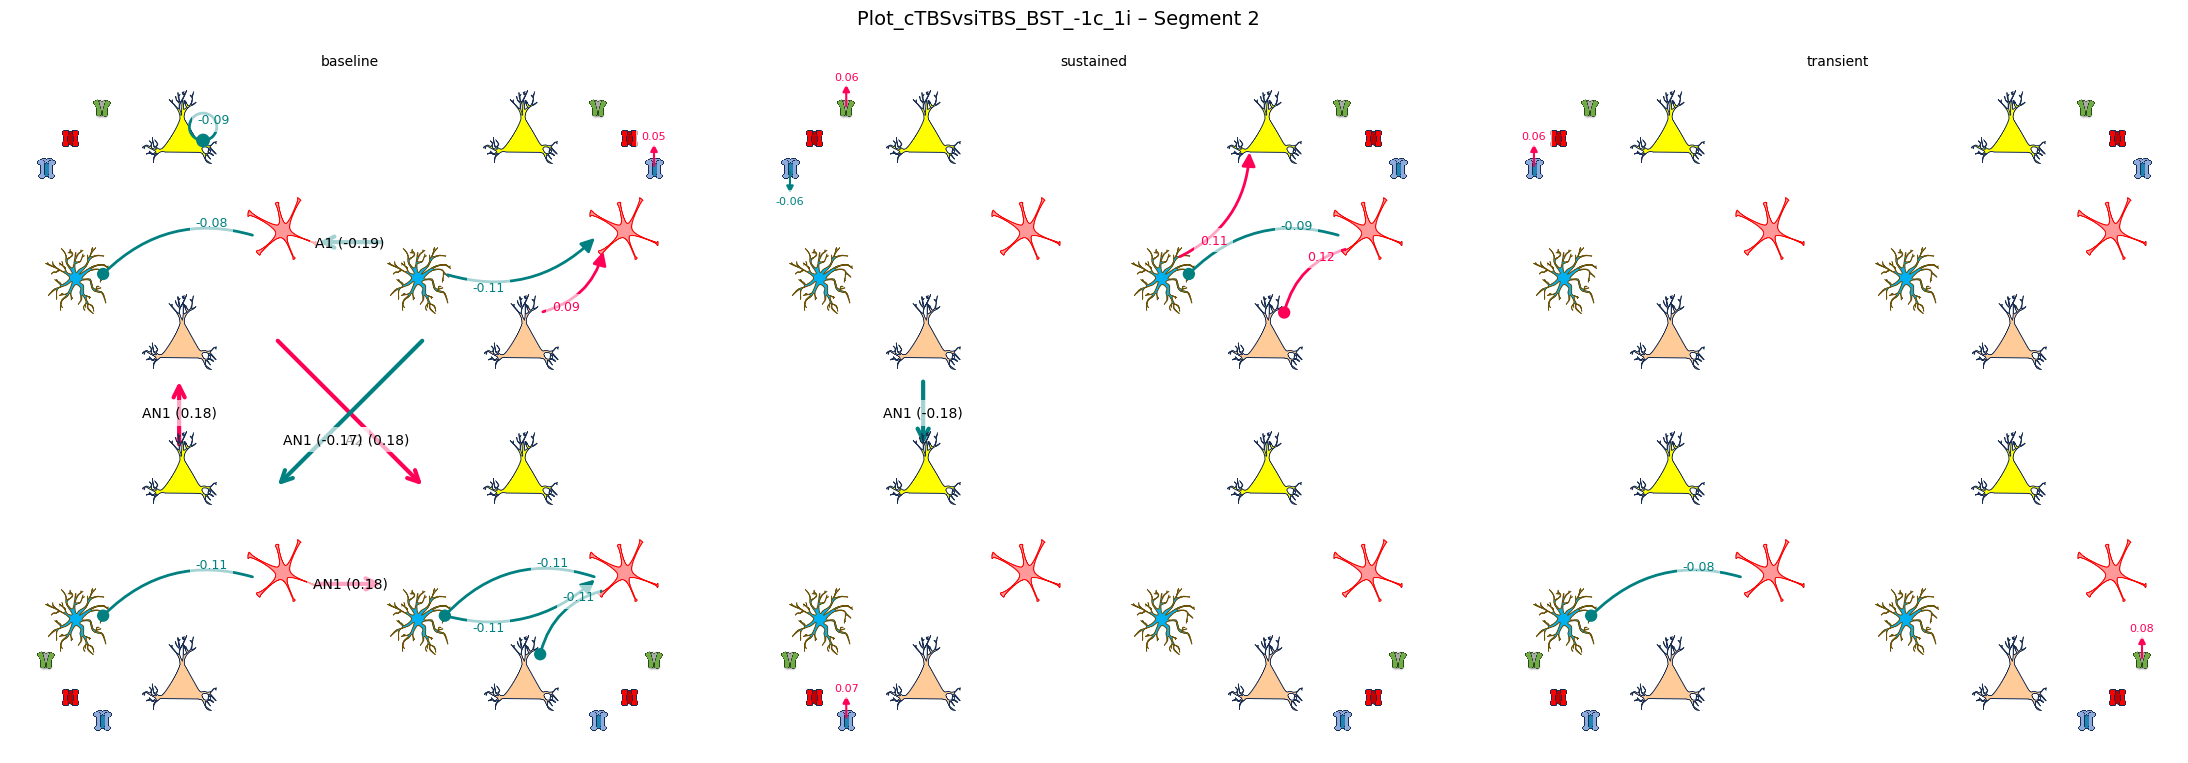

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.sparse import issparse
import networkx as nx
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox  # used by label/artist overlap utilities
from collections import defaultdict     # used for simple grouping and counting

# -----------------------------------------------------------------------------
# Export helpers (additional raster formats and color spaces)
# -----------------------------------------------------------------------------
import io
from PIL import Image

# =============================================================================
# Overview
# =============================================================================
# This script renders DCM connectivity schematics from MATLAB .mat outputs
# (Results.PEB_thresholded). It visualizes:
#   • Extrinsic connections (A/AN terms) between brain areas
#   • Intrinsic connections (H terms) within areas
#   • Ion-channel effects (T terms) drawn as per-area icons with up/down arrows

# -----------------------------------------------------------------------------
# Visual encoding for arrow polarity
# -----------------------------------------------------------------------------
POS_COLOR = '#FF0056'   # positive effect
NEG_COLOR = '#008080'   # negative effect

def fmt_trunc_str(x, ndigits=2):
    """Truncate a numeric value to a fixed number of decimals without rounding."""
    s = str(x)
    if "." in s:
        whole, frac = s.split(".", 1)
        frac = (frac + "0"*ndigits)[:ndigits]
        return f"{whole}.{frac}"
    else:
        return f"{s}.{'0'*ndigits}"

# -----------------------------------------------------------------------------
# Layout and style knobs (tuned to match prior figures)
# -----------------------------------------------------------------------------
ICON_ZOOM               = 0.35
SHAPE_ICON_ZOOM         = 0.1
SHAPE_ARROW_LENGTH      = 0.8
GRID_SPACING            = 10
REGION_RADIUS           = 3
BASE_OFFSET             = 1.2
LABEL_PADDING           = 0.4
PARALLEL_PADDING        = 0.3
VERTICAL_LABEL_PAD      = 0.9
SCALE_INTRINSIC         = 3
INTRINSIC_ARROW_PADDING = 0.8
CIRCLE_HEAD_RADIUS      = 0.18
CIRCLE_POINTER_SIZE     = CIRCLE_HEAD_RADIUS * 2
FIG_WIDTH_PER           = 8
FIG_HEIGHT              = 8

EXTRINSIC_TRIM          = 1
VERTICAL_THRESH         = 0.10
FILENAME_SUFFIX         = "T"

LABEL_BG_COLOR   = 'white'
LABEL_BG_ALPHA   = 0.65
LABEL_EDGE_COLOR = 'none'

DIAG_LABEL_SHIFT = 0.18
DIAGONAL_PAIRS   = {(1, 4), (2, 3)}

ION_CHANNEL_Y_OFFSETS = {1: -0.10, 2: -0.15, 3:  0.00}
ICON_RING_OFFSET   = 1.5
ICON_ANG_OFFSETS   = {1: 0.0, 2: 0.0, 3: 0.0}
ICON_RADIAL_OFFS   = {1: 0.0, 2: 0.0, 3: 0.0}

# -----------------------------------------------------------------------------
# Self-loop placement and label offsets (per intrinsic node id)
# -----------------------------------------------------------------------------
SELF_LOOP_OFFSETS = {
    1: (-0.4, 0.7),
    2: (0.7,  0.0),
    3: (0.4,  -0.7),
    4: (0.8, 0.0),
}
SELF_LOOP_LABEL_OFFSETS = {
    1: (-0.4, 1.2),
    2: (1.0,  0.2),
    3: (0.0,  -1.2),
    4: (1.0,  0.2),
}

# -----------------------------------------------------------------------------
# Covariate → display title mapping
# -----------------------------------------------------------------------------
RAW_TITLE_MAP = {
    'covariate1': 'baseline',
    'covariate2': 'sustained',
    'covariate3': 'transient'
}

# -----------------------------------------------------------------------------
# Region grid layout and image paths (absolute paths expected)
# -----------------------------------------------------------------------------
region_positions = {
    1: (0, GRID_SPACING),
    2: (GRID_SPACING, GRID_SPACING),
    3: (0, 0),
    4: (GRID_SPACING, 0)
}
intrinsic_base_positions = {
    1: (-1, 0.5),
    2: (0, 2.0),
    3: (1, 1.0),
    4: (0, 0)
}
cell_nodes = {1: "SS", 2: "SP", 3: "II", 4: "DP"}
node_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture6.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture5.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture7.png",
    4: r"D:\DCM_manuscript_figure\pics\Picture8.png"
}
shape_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture10.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture20.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture30.png"
}

# -----------------------------------------------------------------------------
# Self-loop primitive (circle with round head)
# -----------------------------------------------------------------------------
def draw_self_loop_with_circle(ax, position, loop_radius=0.4, color=NEG_COLOR,
                               lw=2, offset=(0, 0), arrow_angle_deg=270,
                               pointer_size=CIRCLE_POINTER_SIZE):
    cx, cy = position[0] + offset[0], position[1] + offset[1]
    loop = patches.Circle((cx, cy), loop_radius,
                          edgecolor=color, facecolor='none',
                          lw=lw, zorder=12)
    ax.add_patch(loop)
    angle = np.deg2rad(arrow_angle_deg)
    bx = cx + loop_radius * np.cos(angle)
    by = cy + loop_radius * np.sin(angle)
    head = patches.Circle((bx, by), pointer_size / 2,
                          edgecolor=color, facecolor=color,
                          zorder=13)
    ax.add_patch(head)
    return loop, head

# -----------------------------------------------------------------------------
# Bounding-box helpers for label/icon overlap nudging
# -----------------------------------------------------------------------------
class TransformedBbox(Bbox):
    """Return a new bbox transformed into a target coordinate system."""
    def __new__(cls, bbox, transform):
        pts = transform.transform(bbox.get_points())
        return Bbox.from_extents(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1])

def _get_text_bbox_in_data(ax, text):
    """Get a Text artist's bounding box in data coordinates (robust fallback)."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bb_disp = text.get_window_extent(renderer=renderer)
    bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
    if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
        x, y = text.get_position()
        eps = 1e-6
        bb_data = Bbox.from_extents(x - eps, y - eps, x + eps, y + eps)
    return bb_data

def _get_artist_bbox_in_data(ax, artist):
    """Generic artist bbox in data coordinates (works with AnnotationBbox)."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    try:
        bb_disp = artist.get_window_extent(renderer=renderer)
        bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
        if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
            raise ValueError
        return bb_data
    except Exception:
        try:
            x, y = artist.xy
        except Exception:
            try:
                x, y = artist.get_position()
            except Exception:
                x, y = (0.0, 0.0)
        eps = 1e-6
        return Bbox.from_extents(x - eps, y - eps, x + eps, y + eps)

def _overlap_amount(a: Bbox, b: Bbox, pad=0.0):
    """
    Compute overlap amounts (dx, dy) between two bounding boxes with optional padding.
    Returns (0, 0) if there is no overlap.
    """
    ax0, ay0, ax1, ay1 = a.x0 - pad, a.y0 - pad, a.x1 + pad, a.y1 + pad
    bx0, by0, bx1, by1 = b.x0 - pad, b.y0 - pad, b.x1 + pad, b.y1 + pad
    overlap_x = min(ax1, bx1) - max(ax0, bx0)
    overlap_y = min(ay1, by1) - max(ay0, by0)  # <-- FIXED TYPO (was by1 twice)
    if overlap_x <= 0 or overlap_y <= 0:
        return 0.0, 0.0
    return overlap_x, overlap_y

def resolve_text_overlaps_axis_fixed(ax, texts, fixed_texts=None, pad=0.18, step=0.10, max_iter=400):
    """Iteratively nudge text labels away from overlaps."""
    if not texts:
        return
    fixed_texts = fixed_texts or []

    for _ in range(max_iter):
        moved = False
        bboxes_mov = [_get_text_bbox_in_data(ax, t) for t in texts]
        bboxes_fix = [_get_text_bbox_in_data(ax, t) for t in fixed_texts] if fixed_texts else []

        for j in range(len(texts)):
            bj = bboxes_mov[j]

            # Move away from fixed obstacles
            for fb in bboxes_fix:
                dx_need, dy_need = _overlap_amount(bj, fb, pad=pad)
                if dx_need > 0 and dy_need > 0:
                    bxc = 0.5 * (bj.x0 + bj.x1); byc = 0.5 * (bj.y0 + bj.y1)
                    axc = 0.5 * (fb.x0 + fb.x1); ayc = 0.5 * (fb.y0 + fb.y1)
                    if dx_need <= dy_need:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction * (dx_need + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction * (dy_need + step)))
                    moved = True

            # Move away from earlier movable labels (i < j)
            for i in range(j):
                bi = bboxes_mov[i]
                dx_need, dy_need = _overlap_amount(bj, bi, pad=pad)
                if dx_need > 0 and dy_need > 0:
                    axc = 0.5 * (bi.x0 + bi.x1); ayc = 0.5 * (bi.y0 + bi.y1)
                    bxc = 0.5 * (bj.x0 + bj.x1); byc = 0.5 * (bj.y0 + bj.y1)
                    if dx_need <= dy_need:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction * (dx_need + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction * (dy_need + step)))
                    moved = True

        if not moved:
            break

# -----------------------------------------------------------------------------
# Ion-channel placement helpers
# -----------------------------------------------------------------------------
def compute_channel_xy(cx, cy, angle_deg, base_radius, y_nudge=0.0):
    """Polar-to-Cartesian placement on a ring around (cx, cy)."""
    x = cx + base_radius * np.cos(np.deg2rad(angle_deg))
    y = cy + base_radius * np.sin(np.deg2rad(angle_deg)) + y_nudge
    return x, y

def adjust_channel_neuron_overlaps(ax, channel_records_by_area, neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25):
    """Push ion-channel icons radially outward when overlapping neuron icons."""
    fig = ax.figure
    for area, ch_list in channel_records_by_area.items():
        neur_list = neuron_artists_by_area.get(area, [])
        if not neur_list or not ch_list:
            continue
        for rec in ch_list:
            ang  = rec['angle_deg']
            r    = rec['radius']
            cx, cy = rec['center']
            yn    = rec['y_nudge']
            artist = rec['artist']

            for _ in range(max_iter):
                fig.canvas.draw()
                ch_bb = _get_artist_bbox_in_data(ax, artist)
                overlap_found = False
                for neur in neur_list:
                    neur_bb = _get_artist_bbox_in_data(ax, neur)
                    dx_need, dy_need = _overlap_amount(ch_bb, neur_bb, pad=pad)
                    if dx_need > 0 and dy_need > 0:
                        overlap_found = True
                        break
                if not overlap_found:
                    break
                r += radial_step
                x, y = compute_channel_xy(cx, cy, ang, r, yn)
                try:
                    artist.xy = (x, y)
                except Exception:
                    artist.set_xy((x, y))
                rec['radius'] = r

# -----------------------------------------------------------------------------
# .mat loader → segments with extrinsic / intrinsic / ion-channel data
# -----------------------------------------------------------------------------
def process_file(mat_file_path):
    """
    Loads Results.PEB_thresholded and returns a list of segments (dicts).
      segment = {
        'cov_extrinsic':    {cov: [(src, tgt, label, Ep), ...], ...},
        'covariate_groups': {cov: [{'label': 'H(...)', 'Ep': val}, ...], ...},
        'cov_shape':        {cov: [(area, shape_idx, Ep), ...], ...},
        'cov_keys_all':     [all covariate keys seen in this segment],
        'segment':          1-based index
      }
    Works with:
      (A) old format: struct array [N x 1] with scalar Ep, string Pnames
      (B) new format: scalar struct with Ep [nSeg*nNames] (can be dense/sparse),
                      Pnames [nNames] (cellstr/char/object)
    """
    import re
    import numpy as np
    import scipy.io as sio
    from scipy.sparse import issparse

    pat_ex    = re.compile(r'(?i)\b(A|AN)\{(\d+)\}\(\s*(\d+)\s*,\s*(\d+)\s*\)')
    pat_shape = re.compile(r'(?i)^covariate\s+(\d+)\s*:\s*T\(\s*(\d+)\s*,\s*(\d+)(?:\s*,\s*\d+)?\s*\)$')

    def to_float(v):
        # robust scalar extractor: handles sparse, numpy scalars, 0-d arrays, python scalars
        try:
            if issparse(v):
                arr = v.toarray()
                return float(np.asarray(arr).squeeze())
        except Exception:
            pass
        try:
            return float(np.asarray(v).squeeze())
        except Exception:
            # last resort
            return float(v)

    def normalize_pnames(pnames_field):
        # unwrap nested 1x1 object arrays and cellstrs
        x = pnames_field
        while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
            x = x.item()
        if isinstance(x, (list, tuple)):
            return [str(s).strip() for s in x]
        if isinstance(x, np.ndarray):
            if x.dtype == object:
                return [str(s).strip() for s in x.ravel()]
            # char/unicode array fallback
            return [str(s).strip() for s in x.ravel()]
        return [str(x).strip()]

    def flatten_numeric(vec_like):
        # vec_like can be dense ndarray, sparse matrix/array, or object array of scalars/sparses
        if issparse(vec_like):
            return np.asarray(vec_like.toarray(), dtype=float).ravel()
        try:
            return np.asarray(vec_like, dtype=float).ravel()
        except Exception:
            return np.array([to_float(x) for x in np.ravel(vec_like)], dtype=float)

    mat = sio.loadmat(mat_file_path, squeeze_me=True, struct_as_record=False)
    if 'Results' not in mat:
        raise KeyError(f"'Results' not found in {mat_file_path}")
    res = mat['Results']
    if not hasattr(res, 'PEB_thresholded'):
        raise KeyError(f"'Results.PEB_thresholded' not found in {mat_file_path}")
    peb = res.PEB_thresholded

    segments = []

    # ----- CASE B: scalar struct with vector fields -----
    if hasattr(peb, 'Ep') and hasattr(peb, 'Pnames'):
        Ep_vec = flatten_numeric(getattr(peb, 'Ep'))
        Pnames_block = normalize_pnames(getattr(peb, 'Pnames'))
        Np = len(Pnames_block)
        if Np == 0:
            raise ValueError("Pnames block is empty in PEB_thresholded.")

        nseg = (len(Ep_vec) // Np) if (len(Ep_vec) % Np == 0 and len(Ep_vec) >= Np) else 1

        for s in range(nseg):
            Ep_s = Ep_vec[s * Np:(s + 1) * Np] if nseg > 1 else Ep_vec

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames_block):
                val = float(Ep_s[i])

                # Ion-channel T(...): keep even when val==0 to place icon
                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                # skip zeros for extrinsic/intrinsic only (clutter control)
                if val == 0:
                    continue

                # split "Covariate X: <connection label>"
                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                # Extrinsic A/AN{ins}(tgt,src)
                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                # Intrinsic H(...)
                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            # collect all cov keys seen in this segment (for ordered_covs)
            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    # ----- CASE A: struct array (old format) -----
    if isinstance(peb, np.ndarray):
        Ep_list, Pnames_list = [], []
        for elem in np.ravel(peb):
            Ep_list.append(to_float(getattr(elem, 'Ep')))
            Pnames_list.append(str(getattr(elem, 'Pnames')).strip())

        Ep = np.asarray(Ep_list, dtype=float)
        Pnames = list(Pnames_list)

        Np = len(Pnames)
        if Np == 0:
            raise ValueError("No parameter names found in PEB_thresholded.")
        nseg = len(Ep) // Np if len(Ep) % Np == 0 else 1

        for s in range(nseg):
            Ep_s = Ep[s * Np:(s + 1) * Np] if nseg > 1 else Ep

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames):
                val = float(Ep_s[i])

                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                if val == 0:
                    continue

                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    raise TypeError("Unrecognized PEB_thresholded format.")



# -----------------------------------------------------------------------------
# Core renderer for a single covariate on a given Axes
# -----------------------------------------------------------------------------
def plot_connectivity_for_covariate(ax, cov, data):
    ax.set_aspect('equal','box')
    ax.axis('off')

    # Region circles (hidden; keep for spacing)
    for pos in region_positions.values():
        ax.add_patch(patches.Circle(pos, REGION_RADIUS,
                                    facecolor='none', edgecolor='none',  # invisible
                                    lw=0, zorder=1))

    # Ion-channel icons and their up/down arrows
    cov_shapes = data.get('cov_shape', {}).get(cov, [])
    shapes_by_area = {}
    for area, shape_idx, ep_val in cov_shapes:
        shapes_by_area.setdefault(area, []).append((shape_idx, ep_val))

    channel_artists_by_area = defaultdict(list)

    base_angles = {1:135, 2:45, 3:225, 4:315}
    spread_deg  = 30

    for area, items in shapes_by_area.items():
        items_sorted = sorted(items, key=lambda x: x[0])
        n = len(items_sorted)
        cx, cy = region_positions[area]

        if n > 1:
            angs = np.linspace(base_angles[area] - spread_deg/2,
                               base_angles[area] + spread_deg/2, n)
        else:
            angs = np.array([base_angles[area]])

        if area in (1, 3):
            angs = angs[::-1]

        for (shape_idx, ep_val), ang in zip(items_sorted, angs):
            ang = ang + ICON_ANG_OFFSETS.get(shape_idx, 0.0)
            r   = REGION_RADIUS + ICON_RING_OFFSET + ICON_RADIAL_OFFS.get(shape_idx, 0.0)

            x0, y0 = compute_channel_xy(cx, cy, ang, r, ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0))

            try:
                img_arr = plt.imread(shape_images[shape_idx])
                img_box = OffsetImage(img_arr, zoom=SHAPE_ICON_ZOOM)
                ab = AnnotationBbox(img_box, (x0, y0), frameon=False, zorder=5)
                ax.add_artist(ab)
                channel_artists_by_area[area].append({
                    'artist': ab, 'angle_deg': ang, 'radius': r,
                    'center': (cx, cy), 'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })
            except FileNotFoundError:
                sc = ax.scatter(x0, y0, s=100, color='gray', zorder=5)
                channel_artists_by_area[area].append({
                    'artist': sc, 'angle_deg': ang, 'radius': r,
                    'center': (cx, cy), 'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })

            if ep_val != 0:
                col = POS_COLOR if ep_val>0 else NEG_COLOR
                dy_arrow = SHAPE_ARROW_LENGTH if ep_val>0 else -SHAPE_ARROW_LENGTH
                ax.annotate('', xy=(x0, y0+dy_arrow), xytext=(x0, y0),
                            arrowprops=dict(arrowstyle='-|>', color=col, lw=1.5),
                            zorder=6)
                ax.text(x0, y0+dy_arrow, fmt_trunc_str(ep_val, 2),
                        color=col, fontsize=8, ha='center',
                        va='bottom' if ep_val>0 else 'top',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=6)

    # Extrinsic edges (between regions) with lane-aware label placement
    cov_ex = data['cov_extrinsic'].get(cov, [])
    grouped_ex = {}
    for src, tgt, lab, ep in cov_ex:
        grouped_ex.setdefault(tuple(sorted((src, tgt))), []).append((src, tgt, lab, ep))

    nonvertical_texts = []
    vertical_texts    = []

    for undirected_pair, conns in grouped_ex.items():
        src0, tgt0, _, _ = conns[0]
        P_src0, P_tgt0 = np.array(region_positions[src0]), np.array(region_positions[tgt0])
        vec_pair = P_tgt0 - P_src0
        L_pair = np.linalg.norm(vec_pair)
        if L_pair == 0:
            continue
        unit_pair = vec_pair / L_pair
        is_vertical_pair = abs(unit_pair[0]) < VERTICAL_THRESH
        u_pair = -unit_pair if unit_pair[1] > 0 else unit_pair

        # Trim central segment for along-edge label placement
        trim = REGION_RADIUS + EXTRINSIC_TRIM
        pair_mid = (P_src0 + P_tgt0) / 2.0
        half_len = (L_pair - 2 * trim) / 2.0
        if half_len < 0:
            half_len = 0
        start_base = pair_mid - u_pair * half_len
        end_base   = pair_mid + u_pair * half_len

        seg_len_pair = float(np.linalg.norm(end_base - start_base))
        t_margin = 0.45
        t_min = t_margin
        t_max = max(0.0, seg_len_pair - t_margin)

        if is_vertical_pair:
            k = len(conns)
            if k > 0 and t_max > t_min:
                segment = (t_max - t_min) / k
                t_positions = [t_min + (i + 0.5) * segment for i in range(k)]
            else:
                t_positions = [0.5 * (t_min + t_max)] * k

        for idx, (src, tgt, lab, ep) in enumerate(conns):
            base_idx = idx - (len(conns)-1)/2
            sign     = 1 if src < tgt else -1
            off_fac  = base_idx * sign

            P_src, P_tgt = np.array(region_positions[src]), np.array(region_positions[tgt])
            vec = P_tgt - P_src
            L = np.linalg.norm(vec)
            unit = vec/L if L else np.zeros(2)
            perp = np.array([-unit[1], unit[0]])

            start = P_src + perp*BASE_OFFSET*off_fac + unit*(REGION_RADIUS + EXTRINSIC_TRIM)
            end   = P_tgt + perp*BASE_OFFSET*off_fac - unit*(REGION_RADIUS + EXTRINSIC_TRIM)

            color = POS_COLOR if ep>0 else NEG_COLOR
            ax.annotate('', xy=tuple(end), xytext=tuple(start),
                        arrowprops=dict(arrowstyle='->', lw=3,
                                        color=color, mutation_scale=20),
                        zorder=3)

            if is_vertical_pair:
                t_i = t_positions[idx]
                base_point = start_base + u_pair * t_i
                lane_shift = (BASE_OFFSET + LABEL_PADDING) * off_fac
                lbl_pos = base_point + perp * lane_shift

                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=10, ha='center', va='center',
                              zorder=4,
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR))
                vertical_texts.append(txt)
            else:
                off_perp = perp*LABEL_PADDING*off_fac
                pad = VERTICAL_LABEL_PAD if abs(unit[0])<VERTICAL_THRESH else PARALLEL_PADDING
                off_para = unit*pad*base_idx if abs(unit[0])<abs(unit[1]) else np.zeros(2)

                if tuple(sorted((src, tgt))) in DIAGONAL_PAIRS:
                    edge_vec   = end - start
                    L_eff      = float(np.linalg.norm(edge_vec))
                    if L_eff > 1e-9:
                        t_frac = min(0.95, max(0.05, 0.5 + DIAG_LABEL_SHIFT))
                        lbl_pos = start + unit * (L_eff * t_frac) + off_perp + off_para
                    else:
                        mid = (start + end)/2
                        lbl_pos = mid + off_perp + off_para
                else:
                    mid = (start + end)/2
                    lbl_pos = mid + off_perp + off_para

                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=10, ha='center', va='center',
                              zorder=4,
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR))
                nonvertical_texts.append(txt)

    resolve_text_overlaps_axis_fixed(
        ax,
        texts=nonvertical_texts,
        fixed_texts=vertical_texts,
        pad=0.18,
        step=0.10,
        max_iter=400
    )

    # Intrinsic (within-region) edges + self-loops and neuron icons
    neuron_artists_by_area = defaultdict(list)

    cov_int = data['covariate_groups'].get(cov, [])
    for roi in region_positions:

        # Optional: duplicate diagnostics for intrinsic edges
        seen = defaultdict(list)  # (roi, src, dst) -> list[(Ep, raw)]
        for ent in cov_int:
            m = re.search(r"\((\d+),(\d+),(\d+)\)", ent['label'])
            if not m:
                continue
            d, s, r = map(int, m.groups())
            if r == roi:
                seen[(roi, s, d)].append((ent['Ep'], ent.get('raw', '<no-raw>')))
        for key, lst in seen.items():
            if len(lst) > 1:
                eps = [float(x[0]) for x in lst]
                raws = [x[1] for x in lst]
                print(f"[Intrinsic DUP] cov='{cov}', ROI={key[0]} {key[1]}→{key[2]} count={len(lst)} Eps={eps}\n"
                      f"    RAW Pnames:\n      - " + "\n      - ".join(raws))

        G = nx.MultiDiGraph()
        for n in cell_nodes:
            G.add_node(n)
        for ent in cov_int:
            if f",{roi})" in ent['label']:
                d,s,r = map(int, re.findall(r"\((\d+),(\d+),(\d+)\)", ent['label'])[0])
                if r == roi:
                    G.add_edge(s, d, Ep=ent['Ep'])

        cent = np.mean(list(intrinsic_base_positions.values()), axis=0)
        pos = {n: tuple(np.array(region_positions[roi]) +
                        SCALE_INTRINSIC*(np.array(p)-cent))
               for n,p in intrinsic_base_positions.items()}

        nonself, selfe = [], []
        for u,v,d in G.edges(data=True):
            (selfe if u==v else nonself).append((u,v,d))

        grouped = {}
        for u,v,d in nonself:
            grouped.setdefault(tuple(sorted((u,v))), []).append((u,v,d))
        for edges in grouped.values():
            for i,(u,v,d) in enumerate(edges):
                rad = 0.3 + 0.05*(i - (len(edges)-1)/2)
                col = POS_COLOR if d['Ep']>0 else NEG_COLOR
                p0,p1 = np.array(pos[u]), np.array(pos[v])
                vec2, L2 = p1-p0, np.linalg.norm(p1-p0)
                if L2>2*INTRINSIC_ARROW_PADDING:
                    uv2 = vec2/L2
                    p0 += uv2*INTRINSIC_ARROW_PADDING
                    p1 -= uv2*INTRINSIC_ARROW_PADDING
                arrow = FancyArrowPatch(p0, p1,
                                       connectionstyle=f"arc3,rad={rad}",
                                       arrowstyle='-|>' if u!=3 else '-',
                                       mutation_scale=20,
                                       color=col, lw=2, zorder=12)
                ax.add_patch(arrow)
                if u == 3:
                    ax.add_patch(patches.Circle(p1, CIRCLE_HEAD_RADIUS,
                                                facecolor=col, zorder=13))
                path = arrow.get_path().transformed(arrow.get_patch_transform())
                mp = path.interpolated(steps=100).vertices[50]
                ax.text(mp[0], mp[1], fmt_trunc_str(d['Ep'], 2),
                        color=col, fontsize=9, ha='center', va='center',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=13)

        for u,_,d in selfe:
            p = pos[u]
            offset = SELF_LOOP_OFFSETS.get(u, (0,0))
            col = POS_COLOR if d['Ep']>0 else NEG_COLOR
            draw_self_loop_with_circle(ax, p, loop_radius=0.4,
                                       color=col, offset=offset)
            label_offset = SELF_LOOP_LABEL_OFFSETS.get(u, (0,0))
            lbl = (p[0] + label_offset[0], p[1] + label_offset[1])
            ax.text(lbl[0], lbl[1], fmt_trunc_str(d['Ep'], 2),
                    color=col, fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR), zorder=14)

        for n, coord in pos.items():
            try:
                im = plt.imread(node_images[n])
                icon = OffsetImage(im, zoom=ICON_ZOOM)
                ab   = AnnotationBbox(icon, coord, frameon=False)
                ax.add_artist(ab)
                neuron_artists_by_area[roi].append(ab)
            except FileNotFoundError:
                sc = ax.scatter(*coord, s=200, color='gray', zorder=10)
                neuron_artists_by_area[roi].append(sc)

    # Push ion-channel icons outward when overlapping neuron icons
    adjust_channel_neuron_overlaps(ax,
                                   channel_records_by_area=channel_artists_by_area,
                                   neuron_artists_by_area=neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25)

    # Final axes extents
    xs = [p[0] for p in region_positions.values()]
    ys = [p[1] for p in region_positions.values()]
    pad = REGION_RADIUS + 1
    extra = SHAPE_ARROW_LENGTH + (max(abs(v) for v in ION_CHANNEL_Y_OFFSETS.values()) if ION_CHANNEL_Y_OFFSETS else 0.0)
    ax.set_xlim(min(xs) - pad - extra, max(xs) + pad + extra)
    ax.set_ylim(min(ys) - pad - extra, max(ys) + pad + extra)
    ax.margins(0.05)

# -----------------------------------------------------------------------------
# Program entry point: parse all files, render all segments, export figures
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    file_paths = [
        r"D:\DCM_manuscript_figure\Plot_ctbs_final_BST_n1c.mat",
        r"D:\DCM_manuscript_figure\Plot_itbs_final_BST_n1i.mat",
        r"D:\DCM_manuscript_figure\Plot_sham_final_BST_n1s.mat",
        r"D:\DCM_manuscript_figure\Plot_ctbs_BST_-1s_1c.mat",
        r"D:\DCM_manuscript_figure\Plot_itbs_BST_-1s_1i.mat",
        r"D:\DCM_manuscript_figure\Plot_cTBSvsiTBS_BST_-1c_1i.mat",
    ]
    all_segments = [process_file(fp) for fp in file_paths]

    # --- NEW: build covs from cov_keys_all (ordered union), not from non-zero buckets ---
    def ordered_covs(all_segs):
        out, seen = [], set()
        for segs in all_segs:
            for seg in segs:
                for k in seg.get('cov_keys_all', []):
                    if k not in seen:
                        seen.add(k)
                        out.append(k)
        # enforce numeric order if needed
        out.sort(key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 1_000_000)
        return out

    covs = ordered_covs(all_segments)
    # -----------------------------------------------------------------------------

    outdir = r'D:\DCM_manuscript_figure'
    os.makedirs(outdir, exist_ok=True)

    for f_idx, (fp, segs) in enumerate(zip(file_paths, all_segments), start=1):
        prefix = re.sub(r'[^\w\.\-]+', '_', os.path.splitext(os.path.basename(fp))[0])

        for seg in segs:
            fig, axs = plt.subplots(
                1, len(covs),
                figsize=(FIG_WIDTH_PER * len(covs), FIG_HEIGHT),
                squeeze=False
            )
            axs = axs.flatten()
            fig.patch.set_facecolor('none')
            for ax in axs:
                ax.set_facecolor('none')

            # One column per covariate
            for j, cov in enumerate(covs):
                plot_connectivity_for_covariate(axs[j], cov, seg)
                key   = cov.replace(" ", "").lower()
                title = RAW_TITLE_MAP.get(key, cov)
                axs[j].set_title(title, fontsize=10)

            # Title & layout
            fig.suptitle(f"{prefix} – Segment {seg['segment']}", fontsize=14)
            fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0)

            base = f"{prefix}_segment{seg['segment']}{FILENAME_SUFFIX}"

            out_svg = os.path.join(outdir, base + '.svg')
            fig.savefig(out_svg, format='svg', bbox_inches='tight', transparent=True)
            print(f"Saved figure to: {out_svg}")

            DPI_EXPORT = 600

            overtime_root = os.path.join(outdir, 'overtime_name')
            subfolders = ['RBG', 'CMYK', 'Grayscale']
            for sub in subfolders:
                os.makedirs(os.path.join(overtime_root, sub), exist_ok=True)

            # Per-subfolder SVG copies
            for sub in subfolders:
                svg_path = os.path.join(overtime_root, sub, base + '.svg')
                fig.savefig(svg_path, format='svg', bbox_inches='tight', transparent=True, dpi=DPI_EXPORT)

            # Render once to high-res PNG, then convert
            buf = io.BytesIO()
            fig.savefig(buf, format='png', dpi=DPI_EXPORT, bbox_inches='tight', facecolor='white')
            buf.seek(0)
            img_rgb = Image.open(buf).convert('RGB')
            img_cmyk = img_rgb.convert('CMYK')
            img_gray = img_rgb.convert('L')

            rbg_dir = os.path.join(overtime_root, 'RBG')
            img_rgb.save(os.path.join(rbg_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_rgb.save(os.path.join(rbg_dir, base + '.jpg'), format='JPEG', quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            cmyk_dir = os.path.join(overtime_root, 'CMYK')
            img_cmyk.save(os.path.join(cmyk_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_cmyk.save(os.path.join(cmyk_dir, base + '.jpg'), format='JPEG', quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            gray_dir = os.path.join(overtime_root, 'Grayscale')
            img_gray.save(os.path.join(gray_dir, base + '.tif'), format='TIFF', dpi=(DPI_EXPORT, DPI_EXPORT))
            img_gray.save(os.path.join(gray_dir, base + '.jpg'), format='JPEG', quality=95, subsampling=0, optimize=True, dpi=(DPI_EXPORT, DPI_EXPORT))

            plt.show()
